In [170]:
import os
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (9, 7)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [172]:
from pfs.utils.butler import Butler
from pfs.utils.fiberids import FiberIds
from pfs.datamodel import PfsDesign, FiberStatus, TargetType
from pfs.datamodel.utils import calculate_pfsDesignId

def makePfsDesignFile(cobraId, x, y, ra=np.NaN, dec=np.NaN, raBoresight=100, decBoresight=100, posAng = 0, arms = 'br', tract=1, patch='1,1',
                      catId=-1, objId=-1, targetType=TargetType.SCIENCE, fiberStatus=FiberStatus.GOOD,
                      filterNames=[], fiberFlux=np.NaN, psfFlux=np.NaN, totalFlux=np.NaN, fiberFluxErr=np.NaN, psfFluxErr=np.NaN, totalFluxErr=np.NaN,
                      guideStars=None):
    #
    # Lookup engineering fibres
    #
    gfm = FiberIds()   # Grand Fiber Map

    isEmpty = (gfm.scienceFiberId == FiberIds.EMPTY)
    isEng = (gfm.scienceFiberId == FiberIds.ENGINEERING)
    isCobra = ~isEmpty & ~isEng
    
    nEng = sum(isEng)
    nCobra = sum(isCobra)
    #
    # Map the cobraIds to fiberIds.  There are three types:
    #   Science
    #   Empty
    #   Engineering
    # We'll start by keeping entries for all three types, then drop the empty ones at the end
    #
    nFiber = len(gfm.scienceFiberId)
    fiberId = gfm.fiberId

    targetType = np.full_like(fiberId, TargetType.SCIENCE)
    targetType[isEng] = TargetType.ENGINEERING
    targetType[isEmpty] = TargetType.UNASSIGNED   # not quite right, but we'll drop them soon enough

    tract = np.full(nFiber, tract)
    tract[isEng] = -1

    patch = np.array(nFiber*[patch])
    patch[isEng] = nEng*["0,0"]

    def setValues(sciVal, engVal, dtype=float):
        res = np.empty(nFiber, dtype=dtype)
        res[isCobra] = sciVal
        res[isEng] = engVal
        res[isEmpty] = res[0]   # we need a valid value

        return res

    ra =  setValues(ra,  100)   # Must not be NaN as they go into the pfsConfigId hash
    dec = setValues(dec, 100)
    x = setValues(x, np.NaN)
    y = setValues(y, np.NaN)

    catId = setValues(catId, -1, int)
    objId = setValues(np.full_like(nCobra, -1), -1, int)
    fiberStatus = setValues(fiberStatus, FiberStatus.GOOD, int)

    #
    # We are ignoring the input fiberFlux etc. arrays for now
    #
    assert np.isnan(fiberFlux) and len(filterNames) == 0
    filterNameArray = len(fiberId)*[filterNames]   # list of filter names

    fiberFlux = np.full((nFiber, len(filterNames)), fiberFlux, dtype=float)
    fiberFluxErr = np.full_like(fiberFlux, psfFlux)

    psfFlux = np.full_like(fiberFlux, psfFlux)      
    psfFluxErr = np.full_like(fiberFlux, psfFluxErr)

    totalFlux = np.full_like(fiberFlux, totalFlux)
    totalFluxErr = np.full_like(fiberFlux, totalFluxErr)

    pfiNominal = np.stack((x, y)).T
    guideStars = guideStars

    pfsDesign = PfsDesign(0x0, raBoresight, decBoresight, posAng, arms, fiberId, tract, patch, ra, dec, catId, objId, targetType,
                          fiberStatus, fiberFlux, psfFlux, totalFlux, fiberFluxErr, psfFluxErr, totalFluxErr, filterNameArray, pfiNominal, guideStars)
    
    pfsDesign = pfsDesign[~isEmpty]
    #isEng = pfsDesign.targetType == TargetType.ENGINEERING
    pfsDesign.pfsDesignId = calculate_pfsDesignId(pfsDesign.fiberId, pfsDesign.ra, pfsDesign.dec)
    
    return pfsDesign

#
#
butler = Butler(configRoot=os.path.join(os.environ["PFS_INSTDATA_DIR"], "data"))

dots = butler.get('black_dots')
cobraId = 1 + np.arange(len(dots))

offset = 0.3   # mm
x = dots.x + np.where(cobraId%2 == 0, dots.r + offset, 0)
y = dots.y

raBoresight, decBoresight = 100, 100
ra = 100 + 1e-3*x
dec = 100 + 1e-3*y

pfsDesign = makePfsDesignFile(cobraId, x, y, ra, dec, raBoresight=raBoresight, decBoresight=decBoresight)
print("0x%x" % pfsDesign.pfsDesignId)

pfsDesign.write()

0x775c81f651aee77


<IPython.core.display.Javascript object>


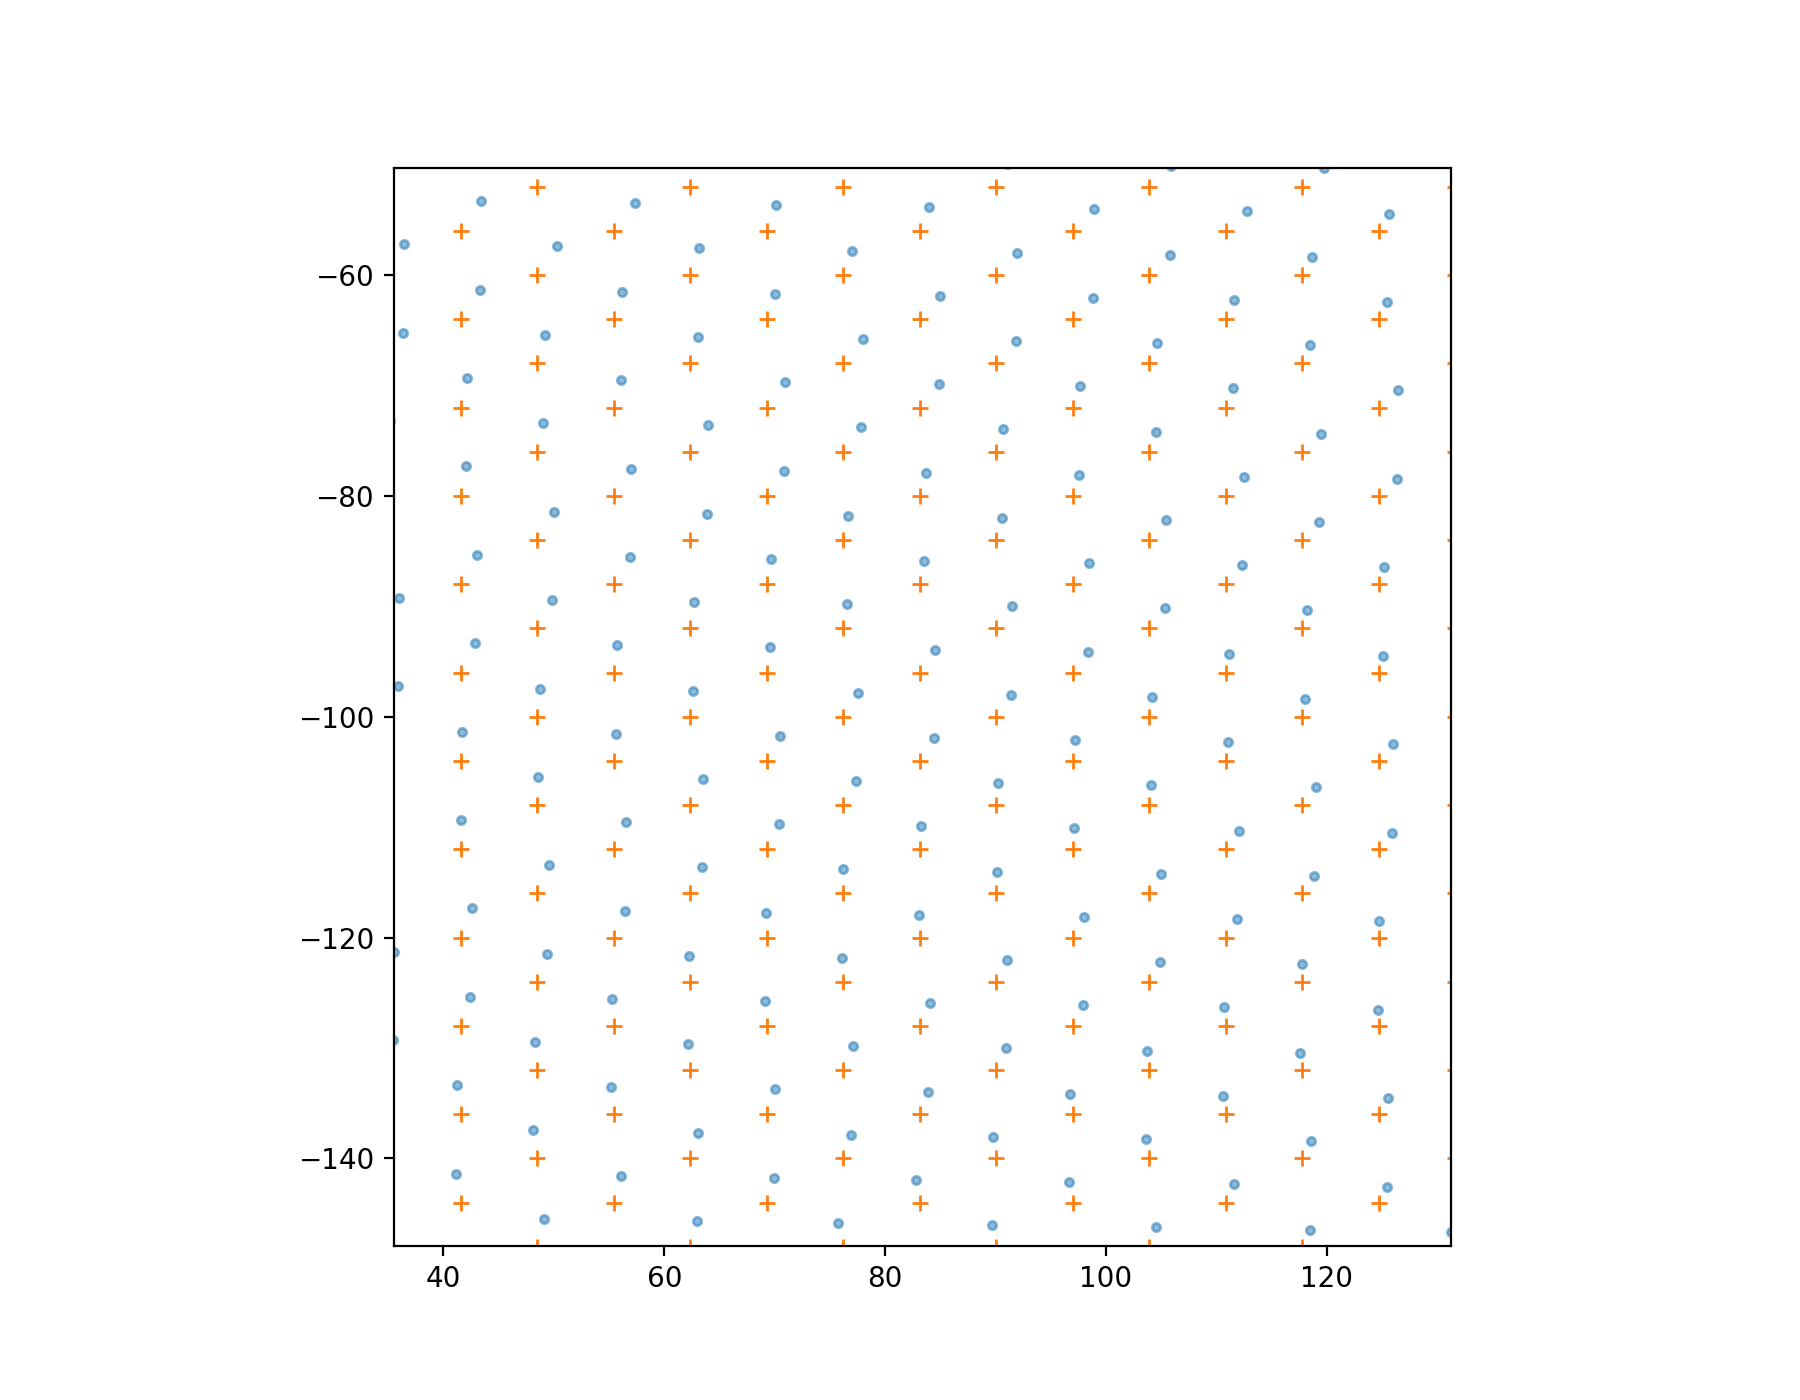

In [98]:
#pfsDesign = PfsDesign.read(0x775c81f651aee77, dirName="/work/rhl/notebooks")

fig = 5; plt.close(fig); fig = plt.figure(fig)

isSci = pfsDesign.targetType == TargetType.SCIENCE
x, y = pfsDesign.pfiNominal[isSci, 0], pfsDesign.pfiNominal[isSci, 1]
plt.plot(x, y, '.', alpha=0.5)

plt.gca().set_aspect('equal');

gfm = FiberIds()   # Grand Fiber Map

isSci = pfsDesign.targetType == TargetType.SCIENCE

xy = np.full((len(pfsDesign), 2), np.NaN)
for i, fid in enumerate(pfsDesign.fiberId[isSci]):
    ind = np.where(gfm.scienceFiberId == fid)[0]
    xy[i] = (gfm.x[ind], gfm.y[ind])
    
plt.plot(xy[:, 0], xy[:, 1], '+');